In [3]:
%load_ext autoreload
%autoreload 2
import os
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# import pandas as pd
import dcmnet
import sys

sys.path.append("/home/boittier/jaxeq/dcmnet")
# print(sys.path)
from dcmnet.models import DCM1, DCM2, DCM3, DCM4, dcm1_params, dcm2_params, dcm3_params, dcm4_params
from dcmnet.modules import MessagePassingModel
from dcmnet.data import prepare_datasets


import functools

import e3x
import flax.linen as nn
import jax
import jax.numpy as jnp

import numpy as np

def atom_centered_dipole(dcm, com, q):
    dipole_out = np.zeros(3)
    for i, _ in enumerate(dcm):
        dipole_out += q[i] * (_ - com)
    # print(dipole_out*2.5417464519)|
    return np.linalg.norm(dipole_out)* 4.80320

import jax
import jax.numpy as jnp
import pickle
from tensorboardX import SummaryWriter
import time
from dcmnet.utils import safe_mkdir
from dcmnet.training import train_model
from dcmnet.training_dipole import train_model_dipo
from pathlib import Path
from dcmnet.data import prepare_batches, prepare_datasets
from dcmnet.utils import apply_model
from dcmnet.plotting import evaluate_dc, plot_esp, plot_model
import optax
from dcmnet.analysis import create_model_and_params
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from dcmnet.data import prepare_batches, prepare_datasets

devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[CpuDevice(id=0)]
cpu
[CpuDevice(id=0)]


<Figure size 640x480 with 0 Axes>

<Figure size 100x100 with 0 Axes>

In [4]:
data = np.load("/pchem-data/meuwly/boittier/home/water_dimer_vpt2.npz")
data

NpzFile '/pchem-data/meuwly/boittier/home/water_dimer_vpt2.npz' with keys: N, E, Q, D, Z...

In [5]:
data["R"].shape

(14000, 7, 3)

In [6]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)
149026//1529

97

In [7]:
train_data, valid_data = prepare_datasets(data_key, 13000, 1000,
                                          ["/pchem-data/meuwly/boittier/home/water_dimer_vpt2.npz"], 
                                          clip_esp=False, natoms=7)

shape (14000, 7, 3)
D (1, 14000, 3)
Q 1 (14000,) 14000
Q (14000,)
R (1, 14000, 7, 3)
(14000, 7, 3)
['R', 'Z', 'F', 'E', 'N', 'D', 'Q']
14000
0 R 14000 (14000, 7, 3)
1 Z 14000 (14000, 7)
2 F 14000 (14000, 7, 3)
3 E 14000 (14000, 1)
4 N 14000 (14000, 1)
5 D 42000 (42000, 1)
6 Q 14000 (14000,)


In [8]:
for _ in train_data.keys():
    print(_, train_data[_].shape)

R (13000, 7, 3)
Z (13000, 7)
F (13000, 7, 3)
E (13000, 1)
N (13000, 1)
D (13000, 1)
Q (13000,)


In [9]:
train_batches = prepare_batches(data_key, train_data, 1, data_keys=["Z", "R", "E", "F"], num_atoms=7)
train_batches[0].keys()

dict_keys(['R', 'Z', 'F', 'E', 'dst_idx', 'src_idx', 'batch_segments'])

In [10]:
valid_batches = prepare_batches(data_key, valid_data, 1, data_keys=["Z", "R", "E", "F"], num_atoms=7)

In [11]:
class EF(nn.Module):
  features: int = 32
  max_degree: int = 3
  num_iterations: int = 2
  num_basis_functions: int = 16
  cutoff: float = 6.0
  max_atomic_number: int = 118  # This is overkill for most applications.


  def energy(self, atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size):
    # 1. Calculate displacement vectors.
    positions_dst = e3x.ops.gather_dst(positions, dst_idx=dst_idx)
    positions_src = e3x.ops.gather_src(positions, src_idx=src_idx)
    displacements = positions_src - positions_dst  # Shape (num_pairs, 3).

    # 2. Expand displacement vectors in basis functions.
    basis = e3x.nn.basis(  # Shape (num_pairs, 1, (max_degree+1)**2, num_basis_functions).
      displacements,
      num=self.num_basis_functions,
      max_degree=self.max_degree,
      radial_fn=e3x.nn.reciprocal_bernstein,
      cutoff_fn=functools.partial(e3x.nn.smooth_cutoff, cutoff=self.cutoff)
    )

    # 3. Embed atomic numbers in feature space, x has shape (num_atoms, 1, 1, features).
    x = e3x.nn.Embed(num_embeddings=self.max_atomic_number+1, features=self.features)(atomic_numbers)

    # 4. Perform iterations (message-passing + atom-wise refinement).
    for i in range(self.num_iterations):
      # Message-pass.
      if i == self.num_iterations-1:  # Final iteration.
        # Since we will only use scalar features after the final message-pass, we do not want to produce non-scalar
        # features for efficiency reasons.
        y = e3x.nn.MessagePass(max_degree=0, include_pseudotensors=False)(x, basis, dst_idx=dst_idx, src_idx=src_idx)
        # After the final message pass, we can safely throw away all non-scalar features.
        x = e3x.nn.change_max_degree_or_type(x, max_degree=0, include_pseudotensors=False)
      else:
        # In intermediate iterations, the message-pass should consider all possible coupling paths.
        y = e3x.nn.MessagePass()(x, basis, dst_idx=dst_idx, src_idx=src_idx)
      y = e3x.nn.add(x, y)

      # Atom-wise refinement MLP.
      y = e3x.nn.Dense(self.features)(y)
      y = e3x.nn.silu(y)
      y = e3x.nn.Dense(self.features, kernel_init=jax.nn.initializers.zeros)(y)

      # Residual connection.
      x = e3x.nn.add(x, y)

    # 5. Predict atomic energies with an ordinary dense layer.
    element_bias = self.param('element_bias', lambda rng, shape: jnp.zeros(shape), (self.max_atomic_number+1))
    atomic_energies = nn.Dense(1, use_bias=False, kernel_init=jax.nn.initializers.zeros)(x)  # (..., Natoms, 1, 1, 1)
    atomic_energies = jnp.squeeze(atomic_energies, axis=(-1, -2, -3))  # Squeeze last 3 dimensions.
    atomic_energies += element_bias[atomic_numbers]

    # 6. Sum atomic energies to obtain the total energy.
    energy = jax.ops.segment_sum(atomic_energies, segment_ids=batch_segments, num_segments=batch_size)

    # To be able to efficiently compute forces, our model should return a single output (instead of one for each
    # molecule in the batch). Fortunately, since all atomic contributions only influence the energy in their own
    # batch segment, we can simply sum the energy of all molecules in the batch to obtain a single proxy output
    # to differentiate.
    return -jnp.sum(energy), energy  # Forces are the negative gradient, hence the minus sign.


  @nn.compact
  def __call__(self, atomic_numbers, positions, dst_idx, src_idx, batch_segments=None, batch_size=None):
    if batch_segments is None:
      batch_segments = jnp.zeros_like(atomic_numbers)
      batch_size = 1

    # Since we want to also predict forces, i.e. the gradient of the energy w.r.t. positions (argument 1), we use
    # jax.value_and_grad to create a function for predicting both energy and forces for us.
    energy_and_forces = jax.value_and_grad(self.energy, argnums=1, has_aux=True)
    (_, energy), forces = energy_and_forces(atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size)

    return energy, forces

In [12]:
model = EF()

In [13]:
model

EF(
    # attributes
    features = 32
    max_degree = 3
    num_iterations = 2
    num_basis_functions = 16
    cutoff = 6.0
    max_atomic_number = 118
)

In [14]:
import functools

import jax
import jax.numpy as jnp
import numpy as np
import optax
from jax.random import randint

from dcmnet.electrostatics import batched_electrostatic_potential, calc_esp
from dcmnet.modules import NATOMS
from dcmnet.utils import reshape_dipole

def mean_squared_loss(energy_prediction, energy_target, forces_prediction, forces_target, forces_weight):
  energy_loss = jnp.mean(optax.l2_loss(energy_prediction, energy_target.reshape(-1)))
  forces_loss = jnp.mean(optax.l2_loss(forces_prediction, forces_target.squeeze()))
  return energy_loss + forces_weight * forces_loss

def mean_absolute_error(prediction, target):
  return jnp.mean(jnp.abs(prediction - target))

In [15]:
@functools.partial(jax.jit, static_argnames=('model_apply', 'optimizer_update', 'batch_size'))
def train_step(model_apply, optimizer_update, batch, batch_size, forces_weight, opt_state, params):
  def loss_fn(params):
    energy, forces = model_apply(
      params,
      atomic_numbers=batch['Z'],
      positions=batch['R'],
      dst_idx=batch['dst_idx'],
      src_idx=batch['src_idx'],
      batch_segments=batch['batch_segments'],
      batch_size=batch_size
    )
    loss = mean_squared_loss(
      energy_prediction=energy,
      energy_target=batch['E'],
      forces_prediction=forces,
      forces_target=batch['F'],
      forces_weight=forces_weight
    )
    return loss, (energy, forces)
  (loss, (energy, forces)), grad = jax.value_and_grad(loss_fn, has_aux=True)(params)
  updates, opt_state = optimizer_update(grad, opt_state, params)
  params = optax.apply_updates(params, updates)
  energy_mae = mean_absolute_error(energy, batch['E'])
  forces_mae = mean_absolute_error(forces, batch['F'])
  return params, opt_state, loss, energy_mae, forces_mae


@functools.partial(jax.jit, static_argnames=('model_apply', 'batch_size'))
def eval_step(model_apply, batch, batch_size, forces_weight, params):
  energy, forces = model_apply(
    params,
    atomic_numbers=batch['Z'],
    positions=batch['R'],
    dst_idx=batch['dst_idx'],
    src_idx=batch['src_idx'],
    batch_segments=batch['batch_segments'],
    batch_size=batch_size
  )
  loss = mean_squared_loss(
    energy_prediction=energy,
    energy_target=batch['E'],
    forces_prediction=forces,
    forces_target=batch['F'],
    forces_weight=forces_weight
  )
  energy_mae = mean_absolute_error(energy, batch['E'])
  forces_mae = mean_absolute_error(forces, batch['F'])
  return loss, energy_mae, forces_mae


def train_model(key, model, train_data, valid_data, num_epochs, learning_rate, forces_weight, batch_size):
  # Initialize model parameters and optimizer state.
  key, init_key = jax.random.split(key)
  optimizer = optax.adam(learning_rate)
  dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(train_data['Z'][0]))
  params = model.init(init_key,
    atomic_numbers=train_data['Z'][0],
    positions=train_data['R'][0],
    dst_idx=dst_idx,
    src_idx=src_idx,
  )
  opt_state = optimizer.init(params)

  # Batches for the validation set need to be prepared only once.
  key, shuffle_key = jax.random.split(key)
  valid_batches = prepare_batches(shuffle_key, valid_data, batch_size,num_atoms=7, 
                                  data_keys=['R', 'Z', 'F', 'E', 'dst_idx', 'src_idx', 'batch_segments'])

  # Train for 'num_epochs' epochs.
  for epoch in range(1, num_epochs + 1):
    # Prepare batches.
    key, shuffle_key = jax.random.split(key)
    train_batches = prepare_batches(shuffle_key, train_data, batch_size,num_atoms=7,
                                    data_keys=['R', 'Z', 'F', 'E', 'dst_idx', 'src_idx', 'batch_segments'])

    # Loop over train batches.
    train_loss = 0.0
    train_energy_mae = 0.0
    train_forces_mae = 0.0
    for i, batch in enumerate(train_batches):
      params, opt_state, loss, energy_mae, forces_mae = train_step(
        model_apply=model.apply,
        optimizer_update=optimizer.update,
        batch=batch,
        batch_size=batch_size,
        forces_weight=forces_weight,
        opt_state=opt_state,
        params=params
      )
      train_loss += (loss - train_loss)/(i+1)
      train_energy_mae += (energy_mae - train_energy_mae)/(i+1)
      train_forces_mae += (forces_mae - train_forces_mae)/(i+1)

    # Evaluate on validation set.
    valid_loss = 0.0
    valid_energy_mae = 0.0
    valid_forces_mae = 0.0
    for i, batch in enumerate(valid_batches):
      loss, energy_mae, forces_mae = eval_step(
        model_apply=model.apply,
        batch=batch,
        batch_size=batch_size,
        forces_weight=forces_weight,
        params=params
      )
      valid_loss += (loss - valid_loss)/(i+1)
      valid_energy_mae += (energy_mae - valid_energy_mae)/(i+1)
      valid_forces_mae += (forces_mae - valid_forces_mae)/(i+1)

    # Print progress.
    print(f"epoch: {epoch: 3d}                    train:   valid:")
    print(f"    loss [a.u.]             {train_loss : 8.3f} {valid_loss : 8.3f}")
    print(f"    energy mae [kcal/mol]   {train_energy_mae: 8.3f} {valid_energy_mae: 8.3f}")
    print(f"    forces mae [kcal/mol/Å] {train_forces_mae: 8.3f} {valid_forces_mae: 8.3f}")


  # Return final model parameters.
  return params

In [16]:
params = train_model(
    train_key,
    model,
    train_data,
    valid_data,
    10,
    0.001, 
    100,
    1,
    # None
)

epoch:   1                    train:   valid:
    loss [a.u.]               11.350    2.093
    energy mae [kcal/mol]      0.513    0.090
    forces mae [kcal/mol/Å]    0.185    0.101
epoch:   2                    train:   valid:
    loss [a.u.]                4.999    1.391
    energy mae [kcal/mol]      0.288    0.244
    forces mae [kcal/mol/Å]    0.095    0.072
epoch:   3                    train:   valid:
    loss [a.u.]                4.559    4.914
    energy mae [kcal/mol]      0.231    0.309
    forces mae [kcal/mol/Å]    0.076    0.181
epoch:   4                    train:   valid:
    loss [a.u.]                4.374    1.565
    energy mae [kcal/mol]      0.206    0.180
    forces mae [kcal/mol/Å]    0.067    0.072
epoch:   5                    train:   valid:
    loss [a.u.]                4.240    1.249
    energy mae [kcal/mol]      0.183    0.076
    forces mae [kcal/mol/Å]    0.063    0.063
epoch:   6                    train:   valid:
    loss [a.u.]                4.1

In [17]:
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
import py3Dmol

In [62]:
@jax.jit
def evaluate_energies_and_forces(atomic_numbers, positions, dst_idx, src_idx):
  return model.apply(params,
    atomic_numbers=atomic_numbers,
    positions=positions,
    dst_idx=dst_idx,
    src_idx=src_idx,
  )


class MessagePassingCalculator(ase_calc.Calculator):
  implemented_properties = ["energy", "forces"]

  def calculate(self, atoms, properties, system_changes = ase.calculators.calculator.all_changes):
    ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
    dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(atoms))
    energy, forces = evaluate_energies_and_forces(
      atomic_numbers=atoms.get_atomic_numbers(),
      positions=atoms.get_positions(),
      dst_idx=dst_idx,
      src_idx=src_idx
    )

    self.results['energy'] = energy.squeeze() * ase.units.kcal/ase.units.mol
    self.results['forces'] = forces * ase.units.kcal/ase.units.mol

In [78]:
# Initialize atoms object and attach calculator.
atoms = ase.Atoms(train_data['Z'][10][:6], train_data['R'][10][:6])
atoms.set_calculator(MessagePassingCalculator())

# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view = py3Dmol.view()
view.addModel(xyz.getvalue(), 'xyz')
view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view.show()



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [79]:
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(atoms).run(fmax=0.05)

      Step     Time          Energy          fmax
BFGS:    0 16:03:57       -0.750010        0.235878
BFGS:    1 16:03:57       -0.752474        0.231064
BFGS:    2 16:03:57       -0.769397        0.246887
BFGS:    3 16:03:57       -0.784995        0.080475
BFGS:    4 16:03:57       -0.786864        0.047564


In [80]:
# # Write structure to xyz file.
# xyz = io.StringIO()
# ase_io.write(xyz, atoms, format='xyz')

# # Visualize the structure with py3Dmol.
# view = py3Dmol.view()
# view.addModel(xyz.getvalue(), 'xyz')
# view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
# view.show()

In [81]:
# Parameters.
temperature = 1
timestep_fs = 0.1
num_steps = 1000000

# Draw initial momenta.
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
Stationary(atoms)  # Remove center of mass translation.
ZeroRotation(atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(atoms), 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = atoms.get_positions()
  potential_energy[i] = atoms.get_potential_energy()
  kinetic_energy[i] = atoms.get_kinetic_energy()
  total_energy[i] = atoms.get_total_energy()
  # Occasionally print progress.q
  if i % 1000 == 0:
    print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")

step     0 epot -0.787 ekin  0.001 etot -0.786
step  1000 epot -0.794 ekin  0.009 etot -0.786
step  2000 epot -0.804 ekin  0.019 etot -0.786
step  3000 epot -0.821 ekin  0.035 etot -0.786
step  4000 epot -0.872 ekin  0.086 etot -0.786
step  5000 epot -0.880 ekin  0.094 etot -0.786
step  6000 epot -0.881 ekin  0.095 etot -0.786
step  7000 epot -0.879 ekin  0.093 etot -0.786
step  8000 epot -0.879 ekin  0.093 etot -0.786
step  9000 epot -0.879 ekin  0.093 etot -0.786
step 10000 epot -0.880 ekin  0.094 etot -0.786
step 11000 epot -0.879 ekin  0.093 etot -0.786
step 12000 epot -0.878 ekin  0.092 etot -0.786
step 13000 epot -0.878 ekin  0.092 etot -0.786
step 14000 epot -0.878 ekin  0.092 etot -0.786
step 15000 epot -0.878 ekin  0.092 etot -0.786
step 16000 epot -0.878 ekin  0.092 etot -0.786
step 17000 epot -0.878 ekin  0.092 etot -0.786
step 18000 epot -0.878 ekin  0.092 etot -0.786
step 19000 epot -0.878 ekin  0.092 etot -0.786
step 20000 epot -0.878 ekin  0.092 etot -0.786
step 21000 ep

In [119]:
# view.getModel().setCoordinates(frames[::10000], 'array')
# view.animate({'loop': True, 'interval': 0.1})
# # view.show()

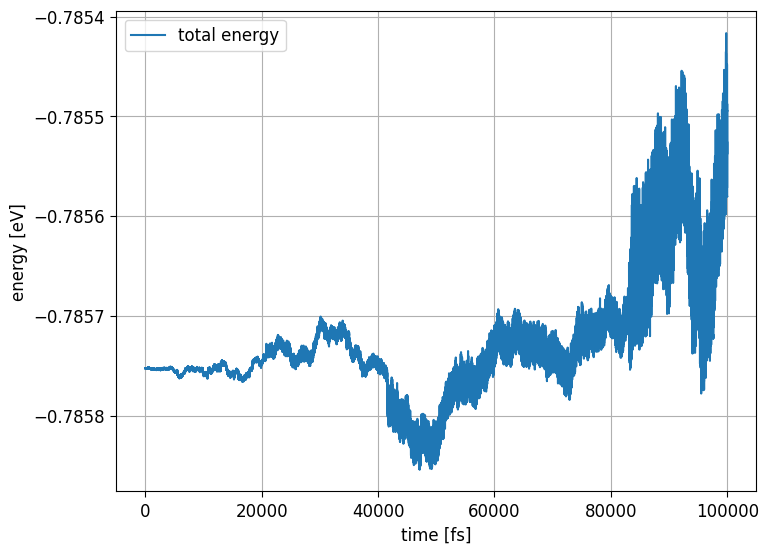

In [95]:
%matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
# plt.plot(time, potential_energy, label='potential energy')
# plt.plot(time, kinetic_energy, label='kinetic energy')
plt.plot(time, total_energy, label='total energy')
plt.legend()
plt.grid()

In [108]:
r = frames[:,0] - frames[:,2]
r

array([[-0.30280137,  0.54781382, -0.76147672],
       [-0.30303991,  0.54779964, -0.76147319],
       [-0.30327749,  0.54778391, -0.7614673 ],
       ...,
       [-0.21594238,  0.95160007,  0.23131466],
       [-0.21636963,  0.95125866,  0.23223209],
       [-0.21679688,  0.95091343,  0.23314953]])

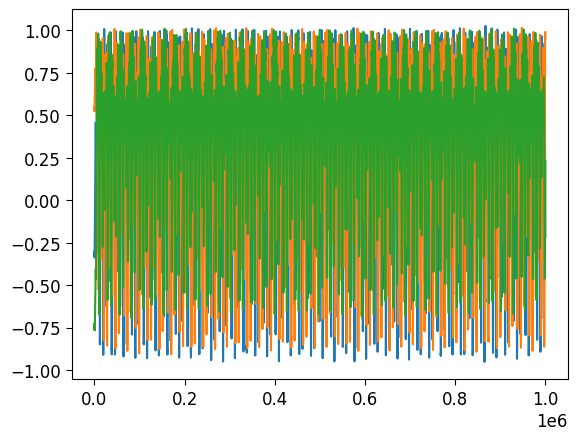

In [109]:
for i in range(3):
    plt.plot(r[:,i])

In [110]:
from statsmodels.tsa.stattools import acovf
10**6/1000

1000.0

In [111]:
# total_dipole_vectors = total_dipole_vectors[NSKIP::]
from ase import units

# Time for speed of light in vacuum to travel 1cm (0.01) in 1fs (1e15)
jiffy = 0.01 / units._c * 1e12

# dipo_list = np.array(total_dipole_vectors)
dtime = timestep_fs
# Frequency range in cm^-1
Nframes = len(r)
print("Nframes: ", Nframes)
Nfreq = int(Nframes / 2) + 1

freq = np.arange(Nfreq) / float(Nframes) / dtime * jiffy

# Dipole-Dipole autocorrelation function
acvx = acovf(r[:, 0], fft=True)
acvy = acovf(r[:, 1], fft=True)
acvz = acovf(r[:, 2], fft=True)
acv = acvx + acvy + acvz

acv = acv * np.blackman(len(r))
spectra = np.abs(np.fft.rfftn(acv)) 

Nframes:  1000000


(0.0, 5e-07)

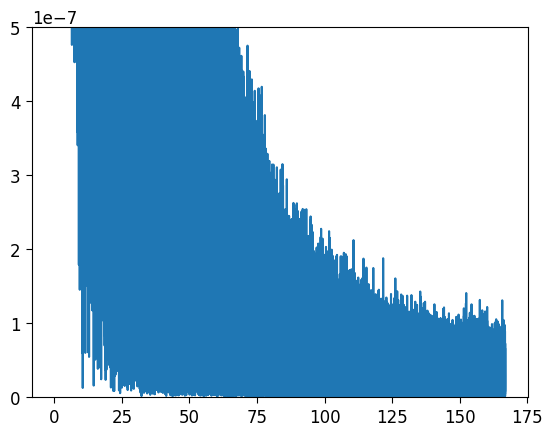

In [118]:
plt.plot(freq, 100*spectra)
plt.ylim(0,0.0000005)
# plt.xlim(100, 150)
# plt.yscale("log")